# TP détection de fréquence / filtrage

Dans ce données, on étudie les variations saisonnières et journalières de la température en un point de la surface de la terre. Les données proviennent de la base Météo France Meteonet disponible, avec leur toolbox Python ici : http://meteonet.umr-cnrm.fr/. On a extrait de la base la mesure de température provenant d'une station située dans le quart Nord-Ouest de la France sur la période 2016-2018. Le fichier correspondant est disponible ici : http://cas.mines-paristech.fr/~dimeglio/temperature.csv. 

Les objectifs du TP sont les suivants : 

 - Afficher et conditionner les données pour l'analyse
 - Faire apparaître les principales composantes spectrales du signal
 - Séparer les variations saisonnières des variations journalières

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
%matplotlib inline

#### (1) Importer les données du fichier \*.csv à l'aide de pandas et afficher les premières lignes du tableau

In [5]:
data = pd.read_csv( 'temperature.csv' )
data.tail()

,NW2016,NW2017,NW2018
8741,269.95,285.65,281.85
8742,269.35,285.55,281.95
8743,268.65,284.65,281.95
8744,269.45,283.85,282.05
8745,268.55,283.45,282.15


#### (2) Avant d'analyser les données, il convient de vérifier leur qualité. Afficher les lignes du tableau où il manque éventuellement des valeurs, à l'aide des méthodes DataFrame.isna() et .any(). Remplacer les données correspondantes par des valeurs nulles, ou toute autre méthode d'interpolation vous paraissant pertinente. 

In [12]:
echantillons = data['NW2016']

In [14]:
echantillons[2672]

290.55

In [7]:
# Créer une colonne de booléens valant True pour chaque ligne où il manque une donnée
idx_na = data.isna().any(axis=1)
# Afficher les lignes du tableau correspondantes
print(data[idx_na])
# Remplacer les valeurs manquantes par des 0
dataClean = data.fillna(0)
# Alternative= remplacer les valeurs manquante par une interpolation à l'ordre 0
dataClean = data.fillna(method = 'ffill') #  will propagate last valid observation forward
# Vérifier le résultat
print(dataClean[idx_na])

      NW2016  NW2017  NW2018
2673     NaN  284.75  293.15
4010  287.65  283.75     NaN
5066     NaN  285.95  290.55
6804     NaN  290.45  293.75
      NW2016  NW2017  NW2018
2673  290.55  284.75  293.15
4010  287.65  283.75  284.45
5066  292.75  285.95  290.55
6804  278.25  290.45  293.75


#### (3) Les données ont été échantillonées avec un pas d'une heure. Afficher la courbe décrivant l'évolution de la température en degrés Celcius au cours du temps pour la période 2016-2018

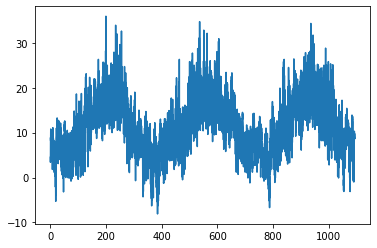

In [15]:
# On choisit d'exprimer le pas d'échantillonage en jour. 
#Il faudra juste faire attention au moment d'interpréter les résultats de la fft, par exemple
dt = 1 / 24 
L = dataClean.shape[0]
t = np.arange(0,3*L*dt,dt)
y = dataClean.values.reshape(3 * L, order = 'F') #the first index changing fastest, and the last index changing slowest. 
plt.plot(t, y - 273.15)

Soit $y$ un signal discret de taille $N$ et $z$ le signal centré en 0 
$$z[k] = y[k] - \frac{1}{N}\sum\limits_{n = 0}^{N-1} y[n]$$
#### (4) Montrer qu'ils ont la même TFD, excepté en le premier coefficient qui vaut 0 pour z.

Notons M la moyenne du signal $y$, i.e. $M = \frac{1}{N}\sum\limits_{n = 0}^{N-1} y[n]$. On a
\begin{align}
Z_k &= \sum_{n=0}^{N-1} z[n] e^{-\frac{2ink\pi}{N}}\\
          &= \sum_{n=0}^{N-1} y[n] e^{-\frac{2ink\pi}{N}} - M\sum_{n=0}^{N-1}e^{-\frac{2ink\pi}{N}}
\end{align}
Comme somme d'une série géométrique de raison $e^{-\frac{2ik\pi}{N}}$, le dernier vaut, si $k \neq 0$
$$\frac{1-e^{-\frac{2iNk\pi}{N}}}{1-e^{-\frac{2ik\pi}{N}}} = 0$$ et vaut $N$ sinon, d'où le résultat.

#### (5) Constuire une fonction calculant et affichant les échantillons du spectre continu d'un signal lui-même échantilloné. On pensera à centrer le signal en 0, à la lumière de la remarque précédente. Préciser quelles hypothèses sur le signal sont nécessaires pour effectuer le lien entre TFD du signal discret et spectre du signal continu.

In [16]:
def myFFT(y, dt, plot = False):
    """
    Computes and plots the samples of the Fourier Transform of a signal
    sampled with a constant time step dt as a function of the continuous
    frequencies

    :param y: signal to be analyzed
    :param dt: sampling time step of the signal, in seconds
    :param plot: flag determining whether the function plots 
    the spectrum or not
    :type y: Numpy array
    :type dt: float

    :return: vector of continuous frequencies (in rad/s), Fast Fourier Transform of the signal y
    :rtype: Numpy arrays
    """
    
    N = len(y)
    freq = np.linspace(0,2*np.pi*(N-1)/N/dt,N)
    Y = np.fft.fft(y-np.mean(y))
    if plot:
        plt.plot(freq,np.abs(Y))
        plt.show()
    return freq, Y

#### (6) Afficher le spectre du signal de température. A quelles périodes correspondent les deux premiers pics clairement visibles ? Cela correspond-il à votre intuition sur le signal physique considéré ? A quoi correspondent les 3e et 4e pics ? Les 4 derniers ? 

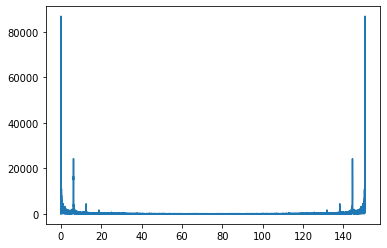

In [17]:
freq, Y = myFFT(y, dt, True)

Les deux premiers pics correspondent à des périodes d'une année et d'un jour, respectivement. Les deux suivants aux harmoniques de la période d'un jour. Les pics de droite correspondent aux fréquences négatives, périodisées. Ils sont symétriques des pics de gauche car le signal est réel.

#### (7) On va maintenant extraire la partie basse fréquence, correspondant aux variations saisonnières, de la partie haute fréquence du signal, à l'aide d'un filtre passe-bas et d'un filtre passe-haut. Où faut-il choisir la pulsation de coupure des filtres ?

On va choisir $ \frac{2\pi}{\text{1 an}} < \omega_c < \frac{2\pi}{\text{1 jour}}$

#### (8) On va utiliser pour cela un filtre tout fait de la bibliothèque scipy.signal : le filtre de Butterworth. Construire un filtre passe-bas et un filtre passe-haut, tous les deux d'ordre 2, et les appliquer au signal à l'aide des fonctions sig.butter et sig.filter. Construire une fonction permettant, étant donné un signal, son pas d'échantillonage et une fréquence de coupure en Hz, et un ordre d'appliquer ce filtre, et d'afficher le résultat

In [18]:
def myFilter(y, dt, N_filter, fc, plot_t):
    # Construire les filtres passe-haut et passe-bas
    num_low, den_low = sig.butter(N_filter, fc, btype='lowpass', fs=1/dt)
    num_high, den_high = sig.butter(N_filter, fc, btype='highpass', fs=1/dt)
    # Appliquer les filtre au signal de température
    y_low = sig.filtfilt(num_low, den_low, y)
    y_high = sig.filtfilt(num_high, den_high, y)   
    
    # Afficher le signal d'origine et le signal filtré passe-bas
    if plot_t:
        plt.figure(2)
        plt.plot(t, y_low, 'b')
        plt.plot(t, y_high,'r')
    return y_high, y_low

#### (9) Afficher et comparer les spectres du signal d'origine et du signal y_high. Augmentez maintenant l'ordre du filtre. 
#### Que constatez-vous vis-à-vis du signal temporel ? Et vis-à-vis du spectre ? 

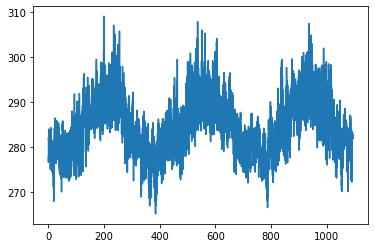

In [19]:
plt.plot(t,y)


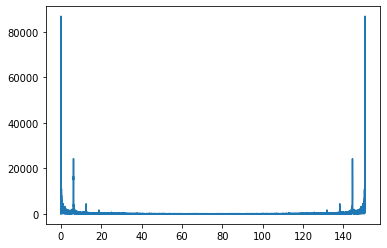

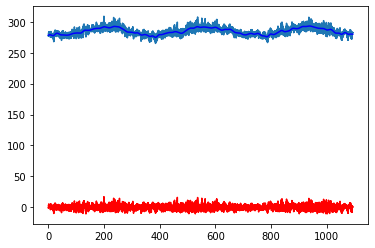

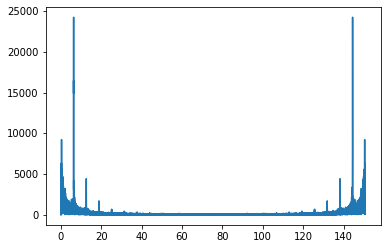

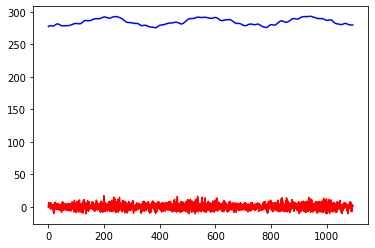

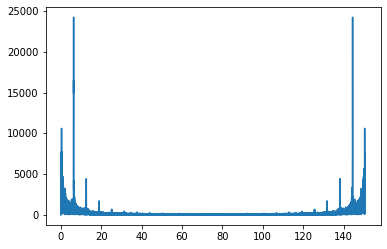

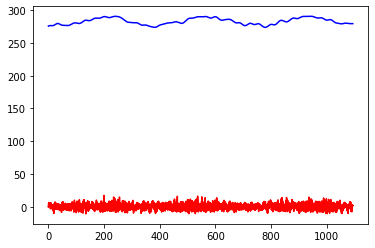

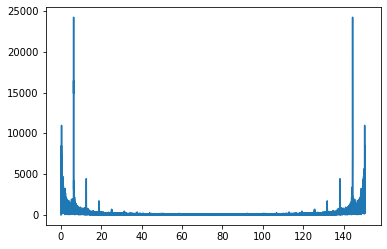

In [20]:
plt.close('all')

# Affichons sur un premier graphe la TFD du signal temporel d'origine
plt.figure(1)
myFFT(y,dt,True)
# Puis, le signal temporel sur un graphe séparé
plt.figure(2)
plt.plot(t,y)

# Affichons maintenant les signaux filtrés pour plusieurs valeurs de N_filter
fc = 1/30
for N_filter in range(2,8,2):
    y_high, y_low = myFilter(y,dt,N_filter,fc,True)
    plt.figure(1)
    myFFT(y_high,dt,True)

En augmentant l'ordre du filtre, on améliore la séparation fréquentielle (gain plus proche de 1 dans la bande passante, plus proche de 0 dans la bande coupée), mais on détériore le transitoire dans le domaine temporel, notamment en raison de l'augmentation de la phase de la fonction de transfert. 